In [1]:
import numpy as np
import xarray as xr
import dask
import scipy.stats as stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from siphon.catalog import TDSCatalog
import os
import json
import requests
from tqdm import tqdm

# this is the URL for PAVICS' THREDDS server which hosts gridded observations. You can
# enter this URL into a browser (but change the .xml to .html) to explore the data catalog
url_gridded_obs = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/gridded_obs/catalog.xml"

# Create Catalog object - this contains the info for the datasets in this directory
cat = TDSCatalog(url_gridded_obs)

for dataset in cat.datasets:
    print(dataset)

nrcan_v2.ncml
nrcan.ncml


In [2]:
# there are two versions of the NRCAN dataset. We will use the more recent one, version 2.
cds = cat.datasets[0] 

# open the dataset using the OPenDAP URL. Passing chunks = 'auto' will speed up processing
# using dask under the hood, and will also allow you to process a larger volume of data 
# over OPenDAP.
nrcan_ds = xr.open_dataset(cds.access_urls["OPENDAP"], chunks = 'auto')

# this will print out an interactive summary of the contents of the dataset
nrcan_ds

<xarray.Dataset>
Dimensions:  (lat: 510, lon: 1068, time: 24837)
Coordinates:
  * lat      (lat) float32 83.46 83.38 83.29 83.21 ... 41.29 41.21 41.12 41.04
  * lon      (lon) float32 -141.0 -140.9 -140.8 -140.7 ... -52.21 -52.13 -52.04
  * time     (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2017-12-31
Data variables:
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(3375, 69, 144), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(3375, 69, 144), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(3375, 69, 144), meta=np.ndarray>
Attributes: (12/15)
    Conventions:          CF-1.5
    title:                NRCAN ANUSPLIN daily gridded dataset : version 2
    history:              Fri Jan 25 14:11:15 2019 : Convert from original fo...
    institute_id:         NRCAN
    frequency:            day
    abstract:             Gridded daily observational dataset produced by Nat...
    ...                   ...
    dataset_id:           NRCAN_anusplin_daily_v2
    version:              2.0
    license_type:         permissive
    license:              https://open.canada.ca/en/open-government-licence-c...
    attribution:          The authors provide this data under the Environment...
    citation:             Natural Resources Canada ANUSPLIN interpolated hist...

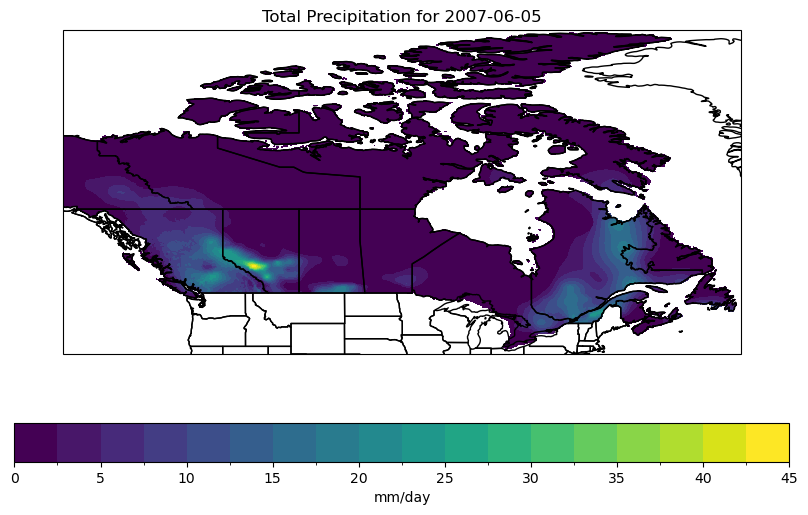

In [3]:
# set up axes with the 'PlateCarree' rectangular coordinate projection for plotting a map
fig, ax = plt.subplots(subplot_kw = dict(projection = ccrs.PlateCarree(), 
                                         transform = ccrs.PlateCarree()),
                       figsize = (10, 6))

# select the precipitation data for a particular day
sample_time = '2007-06-05'
precip_sample = nrcan_ds.pr.sel(time = sample_time) 

# units of the data are mm/s, but we prefer the standard unit of mm/day so let's convert units
# by multiplying by the number of seconds per day
precip_sample = precip_sample * 3600 * 24

# plot the data with 20 filled contours
precip_sample.plot.contourf(ax = ax, 
                            levels = 20, 
                            cbar_kwargs = {'label': 'mm/day', 'orientation': 'horizontal'}
                            )

# add coastlines to the map so we can easily determine what is land and what is not
# (although this dataset only includes data over land so it won't really make much of a difference)
ax.coastlines()

# add provincial borders and make sure they're plotted on top of the contour data
ax.add_feature(cfeature.STATES, zorder = 1)

# plot title
ax.set_title(f"Total Precipitation for {sample_time}")

plt.show()

In [4]:
# subset for Calgary
lat_bnds = [52, 50]
lon_bnds = [-115, -113]

ds_region = nrcan_ds.sel(lat = slice(*lat_bnds), lon = slice(*lon_bnds))

# get the precip data for all times
precip = ds_region.pr * 3600 * 24


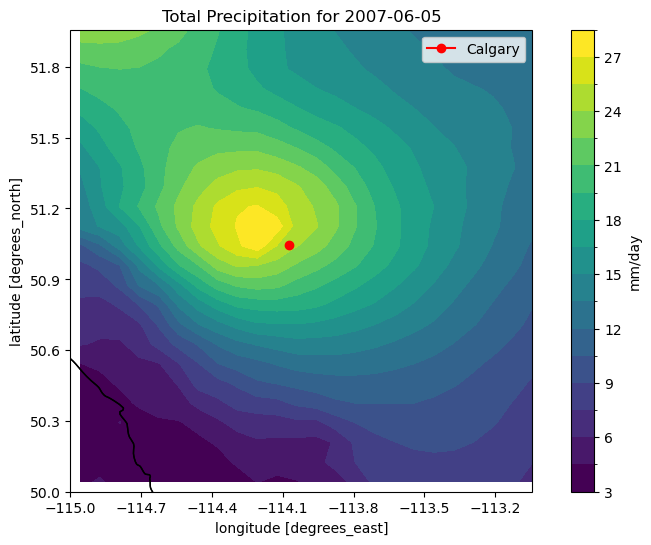

In [5]:
# plot the data on the same day as before
fig, ax = plt.subplots(subplot_kw = dict(projection = ccrs.PlateCarree(), 
                                         transform = ccrs.PlateCarree()),
                       figsize = (10, 6))

precip.sel(time = sample_time).plot.contourf(ax = ax, 
                                             levels = 20, 
                                             cbar_kwargs = {'label': 'mm/day'})
ax.coastlines()
ax.add_feature(cfeature.STATES, zorder = 1)

# plot the location of Calgary as a dot
lat_cgy = 51.0447
lon_cgy = -114.0719
ax.plot(lon_cgy, lat_cgy, marker = 'o', color = 'r', label = 'Calgary')
ax.legend()

# latitude and longitude ticks
ax.set_xticks(np.arange(*lon_bnds, 0.3))
ax.set_yticks(np.arange(*lat_bnds[::-1], 0.3))

# plot title
ax.set_title(f"Total Precipitation for {sample_time}")
plt.show()

In [6]:
# annual maximum precip
precip_annmax = precip.resample(time='Y').max()

# get rid of the chunks along the time dim
# since fitting the GEV is a reduction operation
# over this dimension. Required for use with xr.apply_ufunc.
precip_annmax = precip_annmax.chunk(dict(time = -1))

# define a wrapper function to return the GEV params in a numpy array
# instead of a tuple. This is required for use with xr.apply_ufunc.
fit_GEV_numpy = lambda x: np.array(stats.genextreme.fit(x))

# fit the GEV distribution at each grid cell individually and in parallel
gev_params = xr.apply_ufunc(fit_GEV_numpy,
                            precip_annmax,
                            input_core_dims = [['time']],
                            output_core_dims  = [['param']],
                            output_sizes = {'param': 3},
                            dask = 'parallelized',
                            output_dtypes = [float],
                            vectorize = True)

/var/folders/nt/0d8x2n0x1bdbrmp50m9nn6f00000gn/T/ipykernel_52783/792669526.py:14: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  gev_params = xr.apply_ufunc(fit_GEV_numpy,


In [7]:
# calculate 50-year return period value  - this function will automatically do the calculation
# for each grid cell without any
precip_return50 = stats.genextreme.ppf(1 - (1/50), 
                                       gev_params.isel(param = 0), 
                                       gev_params.isel(param = 1), 
                                       gev_params.isel(param = 2))

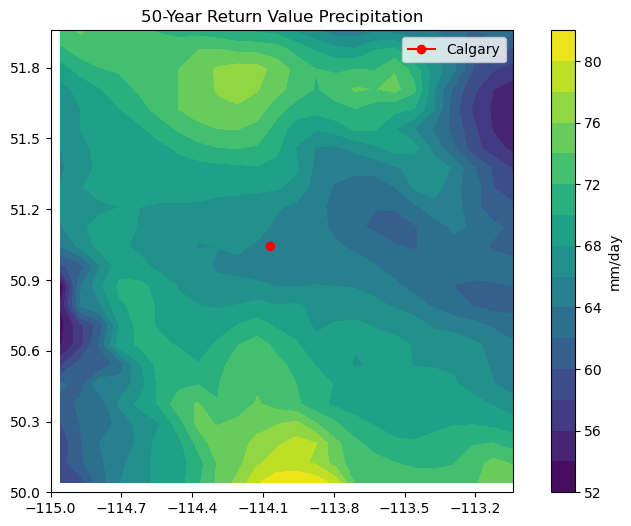

In [8]:
# plot a map of 50-year return values

lons = precip.lon
lats = precip.lat

fig, ax = plt.subplots(subplot_kw = dict(projection = ccrs.PlateCarree(), 
                                         transform = ccrs.PlateCarree()),
                       figsize = (10, 6))
p = ax.contourf(lons, lats, precip_return50, levels = 15)
fig.colorbar(p, label = 'mm/day')
ax.set_title("50-Year Return Value Precipitation")
lat_cgy = 51.0447
lon_cgy = -114.0719
ax.plot(lon_cgy, lat_cgy, marker = 'o', color = 'r', label = 'Calgary')
ax.legend()

# latitude and longitude ticks
ax.set_xticks(np.arange(*lon_bnds, 0.3))
ax.set_yticks(np.arange(*lat_bnds[::-1], 0.3))

plt.show()

In [9]:
# subset for Toronto region
lat_bnds = [45, 42]
lon_bnds = [-81, -78]

ds_region = nrcan_ds.sel(lat = slice(*lat_bnds), lon = slice(*lon_bnds))

# daily maximum temperature data for 1992-2021, similar time period to the station analysis
tmax = ds_region.tasmax.sel(time = ds_region.time.dt.year.isin(range(1992, 2022)))

# divide the data into chunks for automatic parallelization of the calculations
tmax = tmax.chunk(chunks='auto')

In [10]:
# calculate monthly climatology - one line of code!
tmax_monthly_clim = tmax.groupby('time.month').mean('time').compute() 

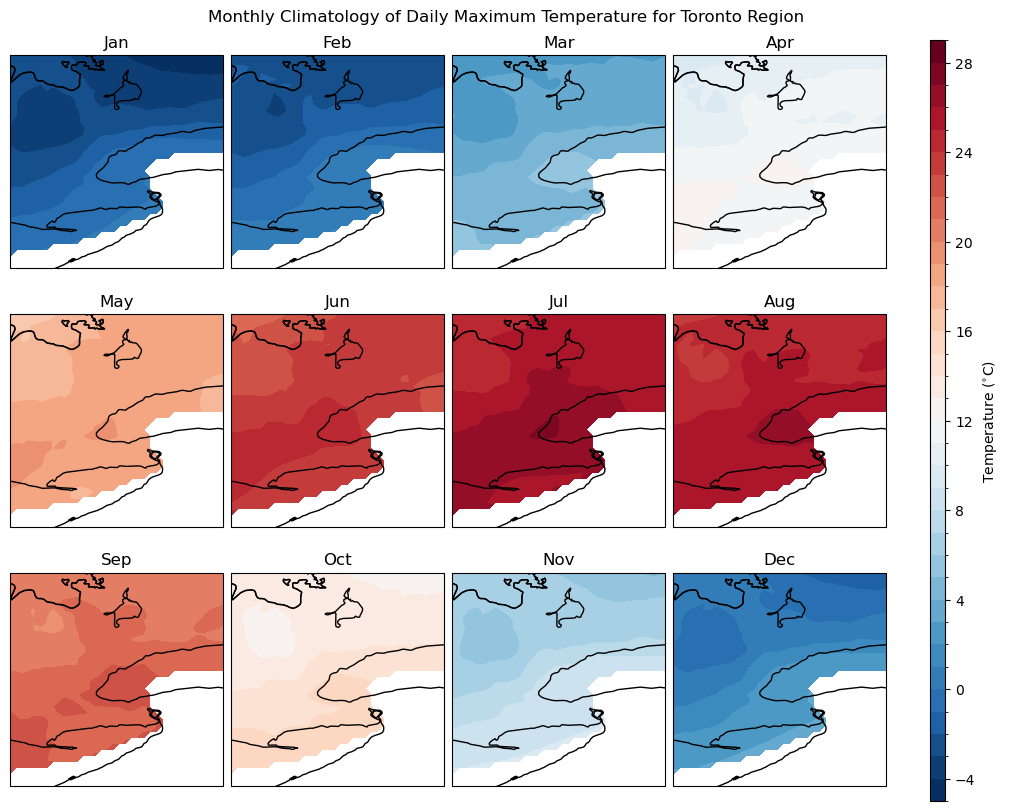

In [11]:
# plot maps in a grid
monthnames = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov' ,'Dec']
fig, axes = plt.subplots(nrows = 3, ncols = 4, 
                         constrained_layout = True,
                         figsize = (10,8), 
                         subplot_kw = dict(projection = ccrs.PlateCarree(), 
                                            transform = ccrs.PlateCarree()))
axes_flat = axes.ravel()
for i in range(len(axes_flat)):
    data = tmax_monthly_clim.sel(month = i + 1) - 273.15 # convert from K to Celsius
    p = data.plot.contourf(ax = axes_flat[i], levels = np.arange(-5, 30, 1), add_colorbar = False)
    axes_flat[i].coastlines()
    axes_flat[i].set_title(monthnames[i])
    # plot the Great Lakes
    axes_flat[i].add_feature(cfeature.LAKES, edgecolor = 'black', facecolor = 'none', zorder = 2) 

fig.colorbar(p, ax = axes_flat.tolist(), 
             label = r'Temperature ($^{\circ}$C)', 
             aspect = 50,
             extendrect = True)

fig.suptitle('Monthly Climatology of Daily Maximum Temperature for Toronto Region')

plt.show()

In [12]:
# create a directory to save the output, only if it doesn't already exist
if not os.path.exists("nrcan_data"):
    os.mkdir("nrcan_data")

# write the daily data to a file in the nrcan_data directory we just created, 
# using a file name that describes the contents
tmax.to_netcdf("nrcan_data/tasmax_NRCAN_sontario.1992-2021.nc")

# write the monthly climatology to a file, again using an informative file name
tmax_monthly_clim.to_netcdf("nrcan_data/tasmax_NRCAN_sontario.monthly_clim.1992-2021.nc")

In [13]:
def download(url, filename):
    print("Downloading ", filename)
    r = requests.get(url, stream=True)
    total_size, block_size = int(r.headers.get('content-length', 0)), 1024
    with open(filename, 'wb') as f:
        for data in tqdm(r.iter_content(block_size),
                         total=total_size//block_size,
                         unit='MiB', unit_scale=True):
            f.write(data)
    if total_size != 0 and os.path.getsize(filename) != total_size:
        print("Downloaded size does not match expected size!\n",
              "FYI, the status code was ", r.status_code)

In [14]:
url_pcic_catalog = "https://data.pacificclimate.org/portal/gridded_observations/catalog/catalog.json"
with requests.get(url_pcic_catalog) as r:
    datasets = json.loads(r.content)
print(datasets.keys())

dict_keys(['tasmin_day_PCIC_BLEND_v1_historical_19500101-20121231_Canada', 'pr_day_TPS_NWNA_v1_historical_19450101-20121231', 'pr_day_ANUSPLIN_CDA_v2012.1_historical_19500101-20101231', 'pr_day_PCIC_BLEND_v1_historical_19500101-20121231_Canada', 'tasmax_day_TPS_NWNA_v1_historical_19450101-20121231', 'tasmin_day_TPS_NWNA_v1_historical_19450101-20121231', 'tasmin_day_ANUSPLIN_CDA_v2012.1_historical_19500101-20101231', 'tasmax_day_PCIC_BLEND_v1_historical_19500101-20121231_Canada', 'tasmax_day_ANUSPLIN_CDA_v2012.1_historical_19500101-20101231', 'wind_day_TPS_NWNA_v1_historical_19450101-20121231'])


In [15]:
url_download = datasets["pr_day_ANUSPLIN_CDA_v2012.1_historical_19500101-20101231"]
url_download_subset = url_download + "?pr[0:9][150:159][330:349]"
filename_to_write = "nrcan_data/test_NRCAN_download.nc"
download(url_download_subset, filename_to_write)

  0%|                                                                                    | 0.00/10.0 [00:00<?, ?MiB/s]

 80%|█████████████████████████████████████████████████████████████▌               | 8.00/10.0 [00:00<00:00, 36.4MiB/s]

11.0MiB [00:00, 48.9MiB/s]                                                                                            

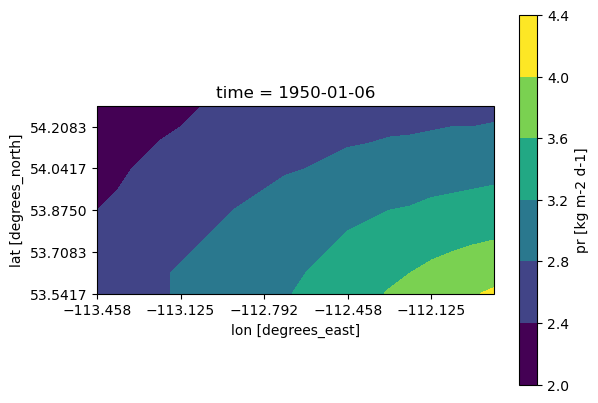

In [16]:
ds_downloaded = xr.open_dataset(filename_to_write)
fig, ax = plt.subplots(subplot_kw = dict(projection = ccrs.PlateCarree(), 
                                         transform = ccrs.PlateCarree()))
ds_downloaded.pr.isel(time = 5).plot.contourf(ax = ax)
ax.coastlines()
ax.set_xticks(ds_downloaded.lon[::4])
ax.set_yticks(ds_downloaded.lat[::2])
plt.show()